# 3. Topic Modeling
In this notebook we will perform the initial topic modeling of the COVID and Agriculture datasets for the publications track of Hercules project. This phase will consist on the preprocessing of each dataset and the training of several topic models to infer the topics of each corpus.

## Setup

In [1]:
%run __init__.py

In [2]:
import pandas as pd
import pyLDAvis
import pyLDAvis.sklearn

pyLDAvis.enable_notebook()

## Common functions

Before we start working with our first dataset, we are going a common set of functionality that will be used in both datasets. First of all, we will define a function to print a word cloud based on the given text:

In [3]:
from wordcloud import WordCloud

import matplotlib.pyplot as plt


def plot_word_cloud(text):
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
    plt.figure(figsize=(8, 6), dpi=100)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()


We also will implement a custom class to perform the preprocessing of texts before they are used by the topic extraction models. This preprocessing will consist of the tokenization of each text, stop word removal and lemmatization. The [Spacy](https://spacy.io) library will be used for this task. Our TextPreprocessor class will allow the use of a custom Spacy model for each different dataset, as we will see later:

In [4]:
from herc_common.text import TextPreprocessor

The following function will be used to show the top terms of each topic extracted by a given model:

In [5]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()


This next set of functions will be use to evaluate our topic extraction models after they have been trained. In the first cell we are making use of the [tmtoolkit](https://tmtoolkit.readthedocs.io/en/latest/) library to obtain the topic coherence of a given model. Specifically, we will be using the _u\_mass_ measure.

The second cell consists of a list of functions to try out several combinations of topics for each given model, and return the model with the best topic coherence amongst them.

In [6]:
import numpy as np

from tmtoolkit.topicmod.evaluate import metric_coherence_gensim


def base_scoring_function(vectorizer, texts, model, X, top_n=10):
    return metric_coherence_gensim(measure='u_mass', dtm=X, 
                                   topic_word_distrib=model.components_,
                                   vocab=np.array([x for x in vectorizer.vocabulary_.keys()]), 
                                   texts=texts, return_mean=True)

In [7]:
MIN_TOPICS = 7
MAX_TOPICS = 30

def try_topics(model_cls, X, scoring_func, **kwargs):
    res = {}
    for num_topics in range(MIN_TOPICS, MAX_TOPICS):
        model = model_cls(n_components=num_topics, random_state=RANDOM_SEED, **kwargs)
        model.fit(X)
        score = scoring_func(model, X)
        res[model] = score
    return res

def print_results_info(model_results):
    best_model = get_best_model(model_results)
    print(f"Best model parameters: {best_model.get_params()}")
    print(f"Topic coherence: {model_results[best_model]}")

def get_best_model(model_results):
    return max(model_results, key=model_results.get)


Finally, we will define a final function to serialize our pipelines so we can load them later on in the following notebooks to obtain the topics of a given piece of text:

In [8]:
from herc_common.utils import save_object

Now that we have defined our common set of functions, we can start working on each dataset.

## Agriculture

### Loading the dataframe

In [9]:
PMC_FILE_PATH = os.path.join(NOTEBOOK_2_RESULTS_DIR, 'pmc_dataframe.pkl')

pmc_df = pd.read_pickle(PMC_FILE_PATH)

### Preprocessing text

In [10]:
publications = pmc_df['text_cleaned'].values

In [11]:
import en_core_web_sm
import en_core_web_md

import en_core_sci_lg

custom_stop_words = {"et","al", "introduction", "fig", "figure", "figures" "figs", "abstract"}

agriculture_preprocessor = TextPreprocessor(en_core_web_md, custom_stop_words)
preprocessed_texts = agriculture_preprocessor.fit_transform(publications)

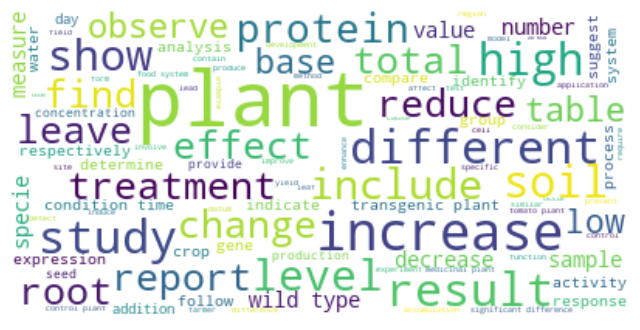

In [12]:
complete_text = ' '.join([' '.join(token) for token in preprocessed_texts])

plot_word_cloud(complete_text)

### LDA

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

def dummy(doc):
    return doc


tf_vectorizer = CountVectorizer(preprocessor=dummy, tokenizer=dummy, ngram_range=(1, 1))
dtm_tf = tf_vectorizer.fit_transform(preprocessed_texts)

In [14]:
from functools import partial

from sklearn.decomposition import LatentDirichletAllocation


lda_scoring_func = lambda clf, X: base_scoring_function(vectorizer=tf_vectorizer,
                                        texts=preprocessed_texts, model=clf, X=X)


lda_results = try_topics(LatentDirichletAllocation, dtm_tf, lda_scoring_func)#, max_iter=100)
lda_results

c:\users\alex\.envs\edma\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


{LatentDirichletAllocation(n_components=7, random_state=42): -1.0837954732908297,
 LatentDirichletAllocation(n_components=8, random_state=42): -1.0471647332538256,
 LatentDirichletAllocation(n_components=9, random_state=42): -0.8194707195743496,
 LatentDirichletAllocation(random_state=42): -1.3031982586603874,
 LatentDirichletAllocation(n_components=11, random_state=42): -1.010456411529431,
 LatentDirichletAllocation(n_components=12, random_state=42): -1.1079660335416823,
 LatentDirichletAllocation(n_components=13, random_state=42): -1.0961940683781926,
 LatentDirichletAllocation(n_components=14, random_state=42): -1.5283454628386743,
 LatentDirichletAllocation(n_components=15, random_state=42): -1.443568286105536,
 LatentDirichletAllocation(n_components=16, random_state=42): -1.2607094700525856,
 LatentDirichletAllocation(n_components=17, random_state=42): -1.2413675494972747,
 LatentDirichletAllocation(n_components=18, random_state=42): -1.537346283526662,
 LatentDirichletAllocation(

In [15]:
print_results_info(lda_results)
best_lda_model = get_best_model(lda_results)

Best model parameters: {'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.7, 'learning_method': 'batch', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 10, 'mean_change_tol': 0.001, 'n_components': 9, 'n_jobs': None, 'perp_tol': 0.1, 'random_state': 42, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}
Topic coherence: -0.8194707195743496


Visualization. Do this with the best model obtained before.

In [16]:
best_lda_model = LatentDirichletAllocation(n_components=9, random_state=RANDOM_SEED)
best_lda_model.fit(dtm_tf)

LatentDirichletAllocation(n_components=9, random_state=42)

In [17]:
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(best_lda_model, tf_feature_names, 10)

Topic #0: food system production habitat grassland agricultural level value change land
Topic #1: plant expression gene root stress level adaptation shoot show yield
Topic #2: base system crop agricultural sensor node farming breeding agriculture datum
Topic #3: soil rice crop high increase yield study practice water residue
Topic #4: plant stress gene increase level root treatment expression protein high
Topic #5: crop grain study rodent high line genotype gene show stage
Topic #6: plant transgenic growth light line protein level high gene Arabidopsis
Topic #7: plant medicinal take decoction Herb informant orally Wild study area
Topic #8: plant root gene non high control virus expression increase show



In [18]:
pyLDAvis.sklearn.prepare(best_lda_model, dtm_tf, tf_vectorizer, mds='tsne')

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
4      111.092506 -133.722946       1        1  26.937082
8       34.946613  107.064590       2        1  23.325540
3      -28.088213 -159.949036       3        1  14.272549
6      147.698074   21.369604       4        1   8.081171
2      -97.501183  126.981384       5        1   7.207977
1       30.312096  -32.794945       6        1   6.569099
7     -155.443665 -118.494690       7        1   6.136062
0     -204.248108   22.596130       8        1   3.908973
5      -79.404678   -6.864717       9        1   3.561547, topic_info=           Term          Freq         Total Category  logprob  loglift
23481     plant  13870.000000  13870.000000  Default  30.0000  30.0000
25886      soil   2457.000000   2457.000000  Default  29.0000  29.0000
25016      rice   1960.000000   1960.000000  Default  28.0000  28.0000
26713    system   1621.000000   1621.000000  Default  27.0000  27.0000
18223      food    838.000000    838.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
13378  analysis     66.034274   1343.827403   Topic9  -5.6001   0.3219
27933     value     64.213312   1222.296054   Topic9  -5.6280   0.3887
23481     plant     71.283510  13870.481621   Topic9  -5.5236  -1.9359
24079   protein     64.390483   1644.332980   Topic9  -5.6253   0.0949
24897    result     64.362636   1798.818023   Topic9  -5.6257   0.0046

[685 rows x 6 columns], token_table=       Topic      Freq   Term
term                         
12         1  0.362619    ABA
12         2  0.052882    ABA
12         4  0.521265    ABA
12         6  0.060437    ABA
69         1  0.992212   ALDH
...      ...       ...    ...
28424      8  0.001869  yield
28424      9  0.071020  yield
28457      1  0.960944   zinc
28457      2  0.032464   zinc
28457      3  0.006493   zinc

[1940 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 9, 4, 7, 3, 2, 8, 1, 6])

In [19]:
from sklearn.pipeline import Pipeline

lda_pipeline = Pipeline([('preprocessing', agriculture_preprocessor),
                         ('vectorizer', tf_vectorizer),
                         ('model', best_lda_model)])

lda_agriculture_pipe_filename = "agriculture_lda_model.pkl"
save_object(lda_pipeline, os.path.join(NOTEBOOK_3_RESULTS_DIR, lda_agriculture_pipe_filename))

In [20]:
dtm_tf_filename = "agriculture_dtm_tf.pkl"

save_object(dtm_tf, os.path.join(NOTEBOOK_3_RESULTS_DIR, dtm_tf_filename))

#### LDA with bigrams

In [21]:
bigram_tf_vectorizer = CountVectorizer(preprocessor=dummy, tokenizer=dummy, ngram_range=(1, 2))
bigram_dtm_tf = bigram_tf_vectorizer.fit_transform(preprocessed_texts)


bigram_lda_scoring_func = lambda clf, X: base_scoring_function(vectorizer=bigram_tf_vectorizer,
                                                               texts=preprocessed_texts, model=clf, X=X)


bigram_lda_results = try_topics(LatentDirichletAllocation, bigram_dtm_tf, bigram_lda_scoring_func)
bigram_lda_results

{LatentDirichletAllocation(n_components=7, random_state=42): -1.2017155538133848,
 LatentDirichletAllocation(n_components=8, random_state=42): -1.5446284596199416,
 LatentDirichletAllocation(n_components=9, random_state=42): -1.3076811616312258,
 LatentDirichletAllocation(random_state=42): -2.101928885340357,
 LatentDirichletAllocation(n_components=11, random_state=42): -2.1838057091196905,
 LatentDirichletAllocation(n_components=12, random_state=42): -1.4993139483543134,
 LatentDirichletAllocation(n_components=13, random_state=42): -1.2578391704462746,
 LatentDirichletAllocation(n_components=14, random_state=42): -1.3800613661406504,
 LatentDirichletAllocation(n_components=15, random_state=42): -1.5280639543890713,
 LatentDirichletAllocation(n_components=16, random_state=42): -2.5504900912110857,
 LatentDirichletAllocation(n_components=17, random_state=42): -2.498077689908472,
 LatentDirichletAllocation(n_components=18, random_state=42): -2.6921871930676833,
 LatentDirichletAllocation

In [22]:
# best_bigram_lda_model = get_best_model(bigram_lda_results)
best_bigram_lda_model = LatentDirichletAllocation(n_components=12)
best_bigram_lda_model.fit_transform(bigram_dtm_tf)

pyLDAvis.sklearn.prepare(best_bigram_lda_model, bigram_dtm_tf, bigram_tf_vectorizer, mds='tsne')

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
0        5.310529  171.049652       1        1  18.393962
4      136.304657   23.800941       2        1  15.896046
1      101.190552  -84.985191       3        1  13.978903
5     -106.824867  148.841736       4        1   9.488505
10     -44.365761   78.632721       5        1   7.803172
6       43.884090   73.474022       6        1   7.727435
7      114.093971  135.933029       7        1   7.293530
2     -119.727142  -72.077179       8        1   6.584039
11     -49.518208   -9.617325       9        1   5.146456
3     -141.938736   40.055210      10        1   2.774194
8       38.731544  -14.776019      11        1   2.573191
9      -10.944340 -107.193344      12        1   2.340568, topic_info=            Term          Freq         Total Category  logprob  loglift
220837     plant  11230.000000  11230.000000  Default  30.0000  30.0000
280210    stress   2238.000000   2238.000000  Default  29.0000  29.0000
271561      soil   2051.000000   2051.000000  Default  28.0000  28.0000
146796      gene   2048.000000   2048.000000  Default  27.0000  27.0000
255078      rice   1641.000000   1641.000000  Default  26.0000  26.0000
...          ...           ...           ...      ...      ...      ...
52965       acid     26.449667    906.667084  Topic12  -6.7882   0.2202
71720       base     23.115842    944.762354  Topic12  -6.9230   0.0444
164111  increase     23.406071   1988.493107  Topic12  -6.9105  -0.6874
139378      find     22.140744    705.126533  Topic12  -6.9661   0.2938
281780     study     22.539005   1741.264820  Topic12  -6.9482  -0.5923

[892 rows x 6 columns], token_table=        Topic      Freq  Term
term                         
32          1  0.009102   ABA
32          2  0.250316   ABA
32          3  0.163843   ABA
32          5  0.523388   ABA
32          8  0.009102   ABA
...       ...       ...   ...
314771      3  0.015178  zinc
314771      5  0.007589  zinc
314771      6  0.007589  zinc
314771      8  0.022766  zinc
314771      9  0.007589  zinc

[2680 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 2, 6, 11, 7, 8, 3, 12, 4, 9, 10])

In [23]:
bigram_lda_pipeline = Pipeline([('preprocessing', agriculture_preprocessor),
                                ('vectorizer', bigram_tf_vectorizer),
                                ('model', best_bigram_lda_model)])

lda_bigram_agriculture_pipe_filename = "agriculture_bigram_lda_model.pkl"
save_object(lda_pipeline, os.path.join(NOTEBOOK_3_RESULTS_DIR, lda_bigram_agriculture_pipe_filename))

### Latent Semantic Analysis (LSA)

In [24]:
from sklearn.decomposition import TruncatedSVD

lsa_scoring_func = lda_scoring_func

lsa_results = try_topics(TruncatedSVD, dtm_tf, lsa_scoring_func)
lsa_results

{TruncatedSVD(n_components=7, random_state=42): -1.2314902894753053,
 TruncatedSVD(n_components=8, random_state=42): -1.6499192126663633,
 TruncatedSVD(n_components=9, random_state=42): -1.6940250130674832,
 TruncatedSVD(n_components=10, random_state=42): -1.7154595809715478,
 TruncatedSVD(n_components=11, random_state=42): -1.7578995591676312,
 TruncatedSVD(n_components=12, random_state=42): -1.8144756438710077,
 TruncatedSVD(n_components=13, random_state=42): -1.766097981452892,
 TruncatedSVD(n_components=14, random_state=42): -1.7454279451984536,
 TruncatedSVD(n_components=15, random_state=42): -1.8121132759461258,
 TruncatedSVD(n_components=16, random_state=42): -1.8880011325921193,
 TruncatedSVD(n_components=17, random_state=42): -1.935695462259353,
 TruncatedSVD(n_components=18, random_state=42): -2.20447991643126,
 TruncatedSVD(n_components=19, random_state=42): -2.077693539861157,
 TruncatedSVD(n_components=20, random_state=42): -2.114721283193569,
 TruncatedSVD(n_components=21

In [25]:
print_results_info(lsa_results)
best_lsa_model = get_best_model(lsa_results)

Best model parameters: {'algorithm': 'randomized', 'n_components': 7, 'n_iter': 5, 'random_state': 42, 'tol': 0.0}
Topic coherence: -1.2314902894753053


In [26]:
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(best_lsa_model, tf_feature_names, 10)

Topic #0: plant stress gene high increase expression level root protein show
Topic #1: system soil food crop rice increase high base level agricultural
Topic #2: decoction orally take Wild medicinal Herb system grinding food area
Topic #3: food system plant virus production value infect regime chain agricultural
Topic #4: stress food system take heat orally decoction Wild gene Herb
Topic #5: root gene expression soil transgenic protein fungus mutant shoot fungal
Topic #6: root MED NUT treatment report application Karst system food informant



In [27]:
from sklearn.decomposition import TruncatedSVD

lsa_pipeline = Pipeline([('preprocessing', agriculture_preprocessor),
                         ('vectorizer', tf_vectorizer),
                         ('model', best_lsa_model)])

lsa_agriculture_pipe_filename = "agriculture_lsa_model.pkl"
save_object(lsa_pipeline, os.path.join(NOTEBOOK_3_RESULTS_DIR, lsa_agriculture_pipe_filename))

### NMF

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(preprocessor=dummy, tokenizer=dummy, ngram_range=(1, 1))
dtm_tfidf = tfidf_vectorizer.fit_transform(preprocessed_texts)

In [29]:
from sklearn.decomposition import NMF

nmf_scoring_func = lambda clf, X: base_scoring_function(vectorizer=tfidf_vectorizer,
                                                        texts=preprocessed_texts, model=clf, X=X)

nmf_results = try_topics(NMF, dtm_tfidf, nmf_scoring_func, max_iter=300)
nmf_results

c:\users\alex\.envs\edma\lib\site-packages\sklearn\decomposition\_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 300 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
c:\users\alex\.envs\edma\lib\site-packages\sklearn\decomposition\_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 300 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
c:\users\alex\.envs\edma\lib\site-packages\sklearn\decomposition\_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 300 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


{NMF(max_iter=300, n_components=7, random_state=42): -1.5045510310166512,
 NMF(max_iter=300, n_components=8, random_state=42): -1.4803092524968477,
 NMF(max_iter=300, n_components=9, random_state=42): -1.9226649767656891,
 NMF(max_iter=300, n_components=10, random_state=42): -1.8599861612310171,
 NMF(max_iter=300, n_components=11, random_state=42): -1.9085165934342176,
 NMF(max_iter=300, n_components=12, random_state=42): -2.2308935839471973,
 NMF(max_iter=300, n_components=13, random_state=42): -2.508880749899875,
 NMF(max_iter=300, n_components=14, random_state=42): -2.7250226050882302,
 NMF(max_iter=300, n_components=15, random_state=42): -2.769664309678864,
 NMF(max_iter=300, n_components=16, random_state=42): -2.4696162199930387,
 NMF(max_iter=300, n_components=17, random_state=42): -2.8691246433641395,
 NMF(max_iter=300, n_components=18, random_state=42): -2.83336239956832,
 NMF(max_iter=300, n_components=19, random_state=42): -3.0333134129026313,
 NMF(max_iter=300, n_components=

In [30]:
print_results_info(nmf_results)
best_nmf_model_2 = get_best_model(nmf_results)

Best model parameters: {'alpha': 0.0, 'beta_loss': 'frobenius', 'init': None, 'l1_ratio': 0.0, 'max_iter': 300, 'n_components': 8, 'random_state': 42, 'shuffle': False, 'solver': 'cd', 'tol': 0.0001, 'verbose': 0}
Topic coherence: -1.4803092524968477


In [31]:
best_nmf_model = NMF(n_components=29, max_iter=400, random_state=RANDOM_SEED)
best_nmf_model.fit(dtm_tfidf)

NMF(max_iter=400, n_components=29, random_state=42)

In [32]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(best_nmf_model, tfidf_feature_names, 10)

Topic #0: mutant wild plant gene type expression sulfite acid senescence level
Topic #1: rice emission soil season paddy winter plot flooding crop cover
Topic #2: household farm CSA crop farmer livestock diversification farming adaptation rainfall
Topic #3: stress plant heat salt tolerance drought gene ABA ALDH expression
Topic #4: gene PVY Rywal potato melon CPB NTN MKK expression sequence
Topic #5: metal toxicity plant soil root concentration heavy xylem uptake acid
Topic #6: transgenic plant gene line salt PME overexpressor Pelo vector tobacco
Topic #7: iot sensor node wireless network Campus Smart communication power device
Topic #8: medicinal plant informant hypertension decoction traditional Herb orally ailment specie
Topic #9: soil residue crop SOC tillage carbon frac till wheat depth
Topic #10: endophyte plant withanolide vindoline somnifera expression root inoculate roseus inoculation
Topic #11: CMV virus plant infect TSWV inoculate bee bumblebee NahG mock
Topic #12: bird habi

In [33]:
from sklearn.pipeline import Pipeline

nmf_pipeline = Pipeline([('preprocessing', agriculture_preprocessor),
                         ('vectorizer', tfidf_vectorizer),
                         ('model', best_nmf_model)])

nmf_agriculture_pipe_filename = "agriculture_nmf_model.pkl"
save_object(nmf_pipeline, os.path.join(NOTEBOOK_3_RESULTS_DIR, nmf_agriculture_pipe_filename))

In [34]:
dtm_tfidf_filename = "agriculture_dtm_tfidf.pkl"

save_object(dtm_tf, os.path.join(NOTEBOOK_3_RESULTS_DIR, dtm_tfidf_filename))

### Corex

In [35]:
import scipy.sparse as ss

from corextopic import corextopic as ct
from corextopic import vis_topic as vt


corex_vectorizer = CountVectorizer(preprocessor=dummy, tokenizer=dummy, binary=True)
binary_tf = corex_vectorizer.fit_transform(preprocessed_texts)
sparse_binary_tf = ss.csr_matrix(binary_tf)

sparse_binary_tf.shape # n_docs x m_words

(126, 28548)

In [36]:
corex_words = corex_vectorizer.get_feature_names()

corex_model = ct.Corex(n_hidden=40, words=corex_words, max_iter=200, verbose=False, seed=RANDOM_SEED)
corex_model.fit(sparse_binary_tf, words=corex_words)

In [37]:
def print_corex_topics(model):
    corex_topics = model.get_topics()
    for n, topic in enumerate(corex_topics):
        topic_words,_ = zip(*topic)
        print('{}: '.format(n) + ','.join(topic_words))

print_corex_topics(corex_model)

0: capillary,temperate,wine,Roth,acute,nearby,western,vouch,poison,popularity
1: cassette,novel,Solanaceae,enlarge,tertiary,mutually,regulated,aspect,drying,event
2: synthesis,expression,RNA,gene,cDNA,transcript,acid,transcription,induce,induction
3: school,foster,stakeholder,opinion,think,Kim,prone,preference,formal,Change
4: PCR,manufacturer,primer,pcr,isolate,kit,gel,rna,instruction,extraction
5: metal,weed,mutation,tube,organ,exhibit,price,pollen,coli,tip
6: refer,space,attention,heterogeneity,horizontal,opportunity,μmol,learning,diet,permission
7: March,custom,hydroxyl,husbandry,February,Northern,Euphorbiaceae,source,pharmacological,belowground
8: supernatant,wash,incubate,homogenize,centrifuge,methanol,concentration,suspension,freeze,mixture
9: scanning,randomized,sunflower,drug,oil,obviously,sensitive,Biotech,pollinator,gently
10: penetrate,sativum,wood,north,pixel,intake,away,worldwide,consistency,product
11: view,deal,significant,fire,coexist,university,pay,concept,partly,cent

Visualizing best number of topics

In [38]:
import matplotlib.pyplot as plt

%matplotlib inline

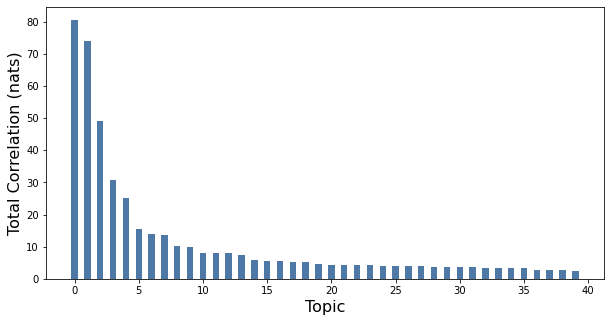

In [39]:
plt.figure(figsize=(10,5))
plt.bar(range(corex_model.tcs.shape[0]), corex_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16)
plt.show()

In [40]:
corex_model.tcs

array([80.56496667, 74.08301014, 49.26622724, 30.73248189, 25.11310672,
       15.58104339, 14.0911575 , 13.55701838, 10.28949711,  9.83679354,
        8.17300574,  8.10510045,  7.87506396,  7.5566357 ,  5.87926185,
        5.53440876,  5.47748778,  5.38008253,  5.29580952,  4.64905607,
        4.43680423,  4.33694614,  4.3289126 ,  4.31021268,  4.01998372,
        3.99584318,  3.95414694,  3.95378957,  3.79183715,  3.69649734,
        3.64670324,  3.55948848,  3.45516046,  3.31902153,  3.27896755,
        3.20604554,  2.87687214,  2.70761452,  2.68303455,  2.38211892])

Building the final model

In [41]:
corex_model = ct.Corex(n_hidden=12, words=corex_words, max_iter=1000, verbose=False, seed=RANDOM_SEED)
corex_model.fit(sparse_binary_tf, words=corex_words)

In [42]:
print_corex_topics(corex_model)

0: accumulation,transcript,amino,accumulate,fold,dna,forest,dark,induction,promoter
1: photosynthetic,induce,biosynthesis,ROS,tissue,synthesis,acid,cell,chlorophyll,regulation
2: manipulation,richness,transfer,modify,succeed,hoc,thin,directly,magnesium,Koch
3: supernatant,wind,incubator,sodium,investment,distil,assay,homogenize,technology,management
4: balance,uniformity,continent,rabbit,carbon,frequency,histidine,holder,malate,stick
5: annual,informant,rosette,desert,child,west,pain,independent,region,Invitrogen
6: official,river,biosynthesize,schematic,Taq,NanoDrop,control,drainage,system,mass
7: coastal,Heat,extrapolate,evening,Service,States,sterilized,injection,role,Winter
8: cultivar,east,circumstance,actually,steel,napus,lock,globally,isotope,compute
9: reservoir,flat,false,design,fungus,exploration,mineralize,screw,clock,fan
10: season,probably,contact,respective,summary,wetland,Quantification,flood,fragment,cassette
11: mda,behaviour,negligible,State,assimilate,condition,Inter

In [43]:
from corextopic import vis_topic as vt

vt.vis_rep(corex_model, column_label=corex_words)

Print topics in text file
